In [1]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [3]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [4]:
sample_sizes = [5423]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../data/Output/mcm/sample_sizes")
atest_mcms, atest_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)
test_mcms = atest_mcms[:,0,0]
test_probs = atest_probs[:,0,0]

In [86]:
sample_idx = 0
run_idx = 0
mcms_range = [3,5]
test_digit = mcms_range[0]

all_byk_pair, all_byk_modspin = utils.get_all_byk_pair(atest_probs, atest_mcms, mcms_range, sample_idx, run_idx)
all_byk = utils.adjust_smaller_icc(all_byk_pair,all_byk_modspin)
all_byk[1].shape

(23, 892, 2)

In [87]:

def same_len_iters_short_long(all_byk_modspin):
    nicc_mods = [len(i) for i in all_byk_modspin] # 33, 30
    mods_long_short_i = np.argsort(nicc_mods)[::-1]

    nicc_mods
    long_iter = np.arange(nicc_mods[mods_long_short_i[0]])
    short_iter = np.append(np.arange(nicc_mods[mods_long_short_i[1]]),[-1 for _ in range(np.abs(np.diff(nicc_mods))[0])])
    return short_iter, long_iter, mods_long_short_i

def predicted_labels_byk_dig(all_byk, all_byk_modspin, mcms_range, dig):
    short_iter, long_iter, mods_long_short_i = same_len_iters_short_long(all_byk_modspin)
    img_dig_i = mcms_range.index(dig)

    out = np.zeros((len(long_iter), 2))
    for i in range(len(long_iter)):

        predicted_labels = np.where(all_byk[mods_long_short_i[0]][long_iter[i],:, img_dig_i] > 
                                all_byk[mods_long_short_i[1]][short_iter[i],:, img_dig_i],
                                mcms_range[mods_long_short_i[0]], mcms_range[mods_long_short_i[1]])

        v, c = np.unique(predicted_labels,return_counts=True)
        out[i, mcms_range.index(v[0])] = c[0]
        out[i, mcms_range.index(v[1])] = c[1]
    return out


In [111]:





dig = 3
predicted_labels_byk_dig(all_byk,all_byk_modspin, mcms_range, dig)


array([[891.,   1.],
       [808.,  84.],
       [787., 105.],
       [833.,  59.],
       [837.,  55.],
       [848.,  44.],
       [833.,  59.],
       [821.,  71.],
       [831.,  61.],
       [818.,  74.],
       [842.,  50.],
       [845.,  47.],
       [851.,  41.],
       [821.,  71.],
       [846.,  46.],
       [871.,  21.],
       [875.,  17.],
       [874.,  18.],
       [873.,  19.],
       [871.,  21.],
       [876.,  16.],
       [871.,  21.],
       [858.,  34.]])

In [55]:
# nicc_mods = [len(i) for i in all_byk_modspin] # 33, 30
# mods_long_short = np.argsort(nicc_mods)[::-1]
# nspin_diff = all_byk_modspin[mods_long_short[0]][:np.min(nicc_mods)]
# nspin_more = np.abs(np.diff(nicc_mods))

# nicc_short = np.append(mods_long_short[1], [-1 for _ in range(nspin_more)])
# # nicc_long = all_byk_modspin[mods_long_short[0]]
# # nspin_diff = np.append(nspin_diff,(  all_byk_modspin[mods_long_short[0]][np.min(nicc_mods):] - all_byk_modspin[mods_long_short[1]][-1]))

# nspin_more, nicc_short.shape, nicc_long.shape,nicc_short

TypeError: only integer scalar arrays can be converted to a scalar index

[19, 32]

In [6]:
# test_probs[0,0,:,0]
# full_mcm_idx = [np.where(test_probs[mcm_i,0,:,0] == -1,)[0][0]-1 for mcm_i in range(10)]
# test_probs.shape

In [9]:
per_image_prob = np.product(test_probs,axis=2,where=test_probs!=-1) # this correct be cause get_complete_testprobs gives the probability for each icc

In [10]:
# digitwise accuracy
max_decision_unit = np.argmax(per_image_prob,axis=0) # out of the 10 mcm seeing the same digit, which one was the most probable
digit_accu = [1-np.count_nonzero(max_decision_unit[k,:] - k)/892 for k in range(10)]
digit_accu
# np.mean(digit_accu)

[0.9730941704035875,
 0.9775784753363229,
 0.9495515695067265,
 0.929372197309417,
 0.9226457399103138,
 0.9204035874439462,
 0.945067264573991,
 0.9047085201793722,
 0.8878923766816144,
 0.8957399103139013]

In [15]:
# for every set of testimages, compute 

# the most likely label the NB classifier gave to each image (10, 892)
predicted_labels_per_image = np.argmax(per_image_prob,axis=0)

v, c = np.unique(predicted_labels_per_image, return_counts=True,axis=1)
# list of tuples: each tuple is each wrong label:count how often each label
unqs = [np.unique(arr, return_counts=True) for arr in predicted_labels_per_image]

idx_arr = np.zeros((10,10))
for i in range(10):
    idx_arr[i][unqs[i][0]] = unqs[i][1]

idx_arr /= 982


np.fill_diagonal(idx_arr, 0)
# np.fill_diagonal(idx_arr,idx_arr.max())
idx_arr


# unqs[i][0]

array([[0.        , 0.        , 0.00305499, 0.00101833, 0.        ,
        0.00509165, 0.00305499, 0.00203666, 0.00916497, 0.00101833],
       [0.        , 0.        , 0.00610998, 0.00101833, 0.00101833,
        0.        , 0.00305499, 0.00101833, 0.00814664, 0.        ],
       [0.00407332, 0.00203666, 0.        , 0.0101833 , 0.00610998,
        0.00101833, 0.00305499, 0.00814664, 0.0101833 , 0.00101833],
       [0.00101833, 0.        , 0.01527495, 0.        , 0.00101833,
        0.0305499 , 0.        , 0.00610998, 0.00916497, 0.00101833],
       [0.        , 0.00101833, 0.00407332, 0.00101833, 0.        ,
        0.00101833, 0.00814664, 0.00407332, 0.00916497, 0.04175153],
       [0.00814664, 0.00203666, 0.        , 0.02647658, 0.        ,
        0.        , 0.00814664, 0.        , 0.02240326, 0.00509165],
       [0.01120163, 0.00407332, 0.00407332, 0.00203666, 0.00407332,
        0.01221996, 0.        , 0.00101833, 0.01120163, 0.        ],
       [0.00101833, 0.00712831, 0.0193482

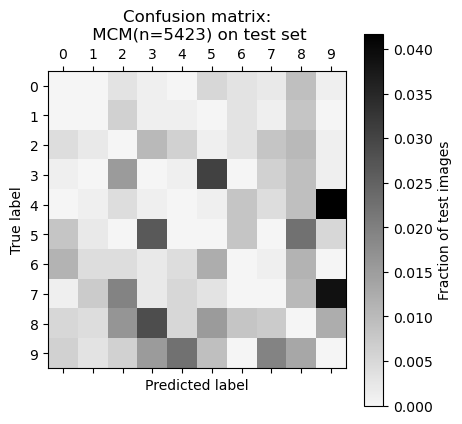

In [16]:
im = myplot.plot_confusion_matrix(idx_arr,10,logScale=False,cmap=myplot.cmap_to_gray("black",reverse=True),title="Confusion matrix:\n MCM(n=5423) on test set")
plt.colorbar(im,).set_label("Fraction of test images")